# Feature engineering

The performances of the binary classifier depend greatly on the type of data used for its training. In this notebook we will use a simple binary classifier and test various datasets to see if one of them stands out, either in terms of model performance or stability of the training process.

We have previously tried two strategies for creating samples for our neural networks, each method is *window based* in that the prediction at time `t` is obtained by feeding a *window* of the timeseries around that time. The two stategies that were implemented so far are : 
   - centered window at time `t`
   - window ending at time `t`

Moreover a sample was labeled `1` if time `t` belongs to one of the events furnished by visual inspection. These events represent the substorm onsets and are usually very short (couple minutes). This results in having two very imbalanced classes in the data.

We take inspiration from the work on predicting presence of an Electric Vehicle based on the electric consumption found at : https://ilmonteux.github.io/EV_charging/
and give a sample the label `1` whenever the corresponding window contains an event. We hope to obtain better balanced classes.


## Common imports

For readability some functionalities were implemented in submodules that are imported now.

[isolated_substorms.dataset](file:///home/aschulz/isolated_substorms/isolated_substorms/dataset.py) : Load all available data.

[isolated_substorms.labels](file:///home/aschulz/isolated_substorms/isolated_substorms/labels.py) : Load all available labels.

[isolated_substorms.train_history](file:///home/aschulz/isolated_substorms/isolated_substorms/train_history.py) : Store the models training history for later analysis.

[isolated_substorms.metrics](file:///home/aschulz/isolated_substorms/isolated_substorms/metrics.py) : F1 score and other metrics.


In [1]:
import sys
sys.path.insert(0,"..")

import datetime
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

# kNN
import sklearn

# plotting utils
import seaborn as sn


# Data loader class
from isolated_substorms.dataset import Dataset
# Label loader class
from isolated_substorms.labels import EventLabels
# Autoencoder classes
from isolated_substorms.train_history import TrainHistory
# f1 score
from isolated_substorms.metrics import f1_score
# data utilities
from isolated_substorms.data_utils import standardize_features

## Load time series data

In [2]:
# get the labels
labels=EventLabels()
print("Number of events         : {}".format(labels.size()))
print("Label timespan           : {}".format(labels.timespan()))

# get AL data
historical_data=Dataset()
# keep only data for which we have labels
labeled_data=historical_data.get_timespan(labels.timespan())
print("Labeled data shape       : {}".format(labeled_data.shape))
p=100.*float(labeled_data.shape[0])/historical_data.data.shape[0]
print("Proportion of total data : {} %".format(p))
labeled_data_mean=np.mean(labeled_data)
labeled_data_std=np.std(labeled_data)
print("Mean                     : {} nT".format(labeled_data_mean))
print("Standard deviation       : {} nT".format(labeled_data_std))

# Normalize the series and set aside the original data for later
original_data=labeled_data
# transform the data a little to make training easier
labeled_data = labeled_data - np.min(labeled_data)
labeled_data=labeled_data ** (1./3.)
labeled_data=(labeled_data - labeled_data_mean) / labeled_data_std


Number of events         : 76
Label timespan           : 1992-10-13 06:27:26 -> 1993-02-15 01:33:40
Labeled data shape       : (179946,)
Proportion of total data : 3.416106383657303 %
Mean                     : -141.652167872584 nT
Standard deviation       : 167.2879219136791 nT


### Creating samples

First we start by creating the datasets we want to compare. We have chosen to take a window size of `180` for our test.

We will take care to create as many samples as there were observations in the input time series, filling missing values with the end values of the series when necessary.

In [3]:
window_size=180
h_w=int(window_size/2)

### Centered window

`x_centered, y_centered` contain the input data to the prediction model and the corresponding labels. 

`y_centered[i]==1` if the `i`-th sample of the original data belongs to a substorm event.

In [4]:
def make_windows(a, w_s):
    n=a.shape[0]
    x=np.zeros((n-w_s, w_s))
    for i in range(n-w_s):
        x[i,:]=a[i:i+w_s].to_numpy()
    return x
x_original=make_windows(original_data, window_size)
x_windows=make_windows(labeled_data, window_size)
x_windows=standardize_features(x_windows)
N=x_windows.shape[0]
# map the indexes to dates
t_centered=[labeled_data.index[i+h_w] for i in range(N)]
# get labels
y_centered=np.array([labels.check_date(t) for t in t_centered])

# count classes
print("Classes:\n\t1: {}\n\t0: {}".format(np.sum(y_centered==1), \
                                         np.sum(y_centered==0)))

Classes:
	1: 354
	0: 179412


Make labels for the second dataset : `y_event_presence[i]==1` if the window `[i-h_w, i+h_w]` contains a substorm event, where `h_w` is half the window size.

In [5]:
# half window size
h_w=int(window_size/2)
t_d=datetime.timedelta(minutes=h_w)
# windows containing an event
y_event_presence=np.array([labels.check_interval(labeled_data.index[i-h_w],\
                                                 labeled_data.index[i+h_w])\
                           for i in range(N)]).astype(int)

# count classes
print("Classes:\n\t1: {}\n\t0: {}".format(np.sum(y_event_presence==1), \
                                         np.sum(y_event_presence==0)))

Classes:
	1: 11807
	0: 167959


## Fitting and predicting



### The classifier

Use the same classifier as in `binary_classifier` notebook.

This class can be imported from the `isolated_substorms.binary_classifier` module.


In [6]:
from isolated_substorms.binary_classifier import BinaryClassifier

For a first implementation we chose an exceedingly simple model : one layer network with a sigmoid activation function. The models input is a `180` size window and its output is composed of two values between 0 and 1 representing the *confidence* of the model in both classes.

In [7]:
class MyBinClass(BinaryClassifier):
    def __init__(self, in_size=window_size):
        super(MyBinClass,self).__init__()
        self.l1=torch.nn.Linear(in_size,128)
        self.l2=torch.nn.Linear(128,128)
        self.l3=torch.nn.Linear(128,2)
    def forward(self, x):
        x=torch.relu(self.l1(x))
        x=torch.relu(self.l2(x))
        x=torch.sigmoid(self.l3(x))
        return x

### Loading the Detector module and testing

`BinaryClassifierDetector` is a member of the `isolated_substorms.binary_classifier` module.

In [8]:
from isolated_substorms.binary_classifier import BinaryClassifierDetector
from isolated_substorms.plot_utils import plot_losses_and_confusion


Test the `BinaryClassifierDetector` on each of the training sets.

Training stop status : validation score not improving. ending training


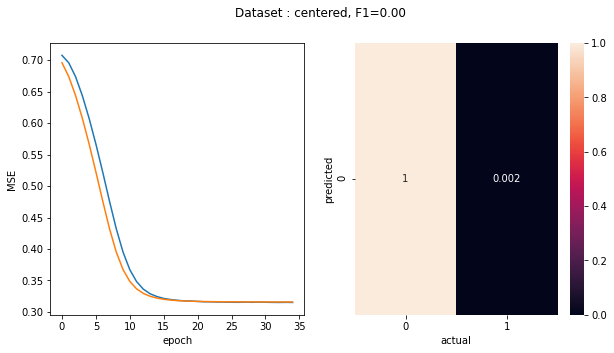

In [9]:
# fit a detector on the centered data

detector = BinaryClassifierDetector(MyBinClass)
detector.fit(x_windows,y_centered,\
             lr=.1,\
             patience=10,\
             validation_tol=1.e-4,\
             verbose=False,\
             max_epochs=1000)
print("Training stop status : {}".format(detector.train_history.stop_status))

fig=plot_losses_and_confusion(detector.model, x_windows, y_centered, "Dataset : {}".format("centered"), figsize=(10,5))

Training stop status : validation score not improving. ending training


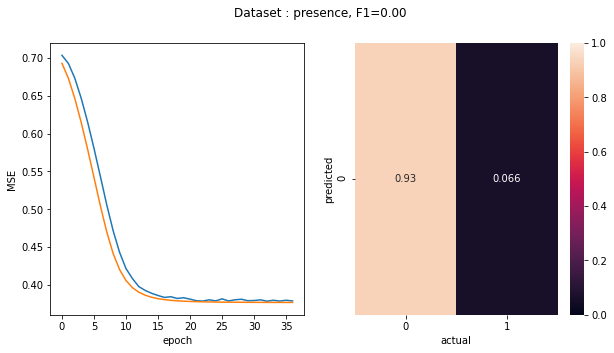

In [10]:
# fit a detector on the event containing data

detector = BinaryClassifierDetector(MyBinClass)
detector.fit(x_windows,y_event_presence,\
             lr=.1,\
             patience=10,\
             validation_tol=1.e-4,\
             max_epochs=1000,\
             verbose=False)

print("Training stop status : {}".format(detector.train_history.stop_status))
fig=plot_losses_and_confusion(detector.model, x_windows, y_event_presence, "Dataset : {}".format("presence"), figsize=(10,5))

By looking at the training results it is unclear which configuration yields the best results. Both models seem (in most cases) to converge towards a degenerate solution (always `0`).

### Class balancing

One of the classes is far more represented in the training data than the other class. We want to remedy this issue.

In [11]:
# equalize classes
def balance_classes(x,y,weights):
    # positive labels
    x_positive=x[y==1]
    n_positive=x_positive.shape[0]
    # negative labels
    x_negative=x[y==0]
    # shuffle the negative labels
    x_negative=sklearn.utils.shuffle(x_negative)
    # concatenate positive and negative samples
    x_temp=np.concatenate((x_positive,x_negative[:n_positive]),axis=0)
    y_temp=np.concatenate((np.ones(n_positive),np.zeros(n_positive)),axis=0)
    return sklearn.utils.shuffle(x_temp,y_temp)
x_balanced,y_balanced=balance_classes(x_windows,y_event_presence,.5)
print("Balanced data shape :\n\tx.shape : {}\n\ty.shape : {}".format(x_windows.shape, y_event_presence.shape))

Balanced data shape :
	x.shape : (179766, 180)
	y.shape : (179766,)


Train the model and predict, hope to see an improvement of the F1 score.

validation increased, exceeded patience


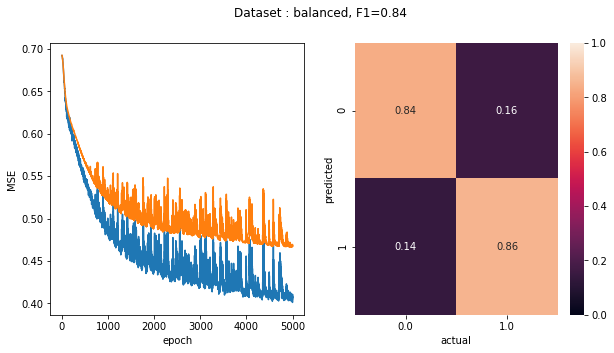

In [12]:
detector =  BinaryClassifierDetector(MyBinClass)
detector.fit(x_balanced,y_balanced,\
             lr=.1,\
             patience=100,\
             validation_tol=1.e-5,\
             max_epochs=5000,\
             verbose=False)
print(detector.train_history.stop_status)
fig=plot_losses_and_confusion(detector, x_balanced,y_balanced, "Dataset : {}".format("balanced"), figsize=(10,5))

In [13]:
# prediction
prediction=detector.predict(x_windows)
# count each class
print("Event count:\n\t0: {}\n\t1: {}".format(np.sum(prediction==0), np.sum(prediction==1)))
# false positive features
fp_mask=(prediction==1) & (y_event_presence==0)
false_positive_features=x_windows[fp_mask]
false_positive_time=np.array(t_centered)[fp_mask]
false_positive_count=false_positive_features.shape[0]
print("False positive count : {}".format(false_positive_count))

Event count:
	0: 136676
	1: 43090
False positive count : 33265


Useless, try majority vote.

In [14]:
def majority_vote(x, voters):
    n=x.shape[0]
    ans=np.empty(n)
    for i in range(n):
        if i<voters:
            c=x[:i+1]
        else:
            c=x[i-voters:i]
        ans[i]=np.argmax(np.bincount(c))
    return ans.astype(int)
mc=majority_vote(prediction, 180)

# transform the prediction to a catalogue of events
def prediction_to_catalogue(x):
    n=x.shape[0]
    event_catalogue=[]
    current_event=None
    for i in range(n):
        if current_event is None:
            if x[i]==1:
                current_event=i
        else:
            if x[i]==0:
                event_catalogue.append([current_event, i-1])
                current_event=None
    return event_catalogue
substorm_events=prediction_to_catalogue(mc)
print("Number of events : {}".format(len(substorm_events)))



Number of events : 182


## Detection results

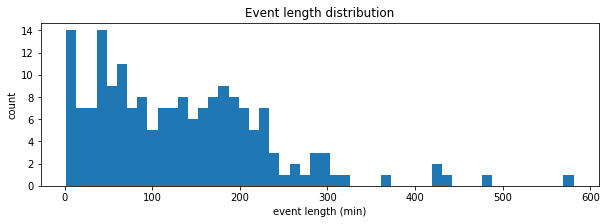

In [15]:
event_lengths=[b-a for [a,b] in substorm_events]
plt.figure(figsize=(10,3))
plt.title("Event length distribution")
plt.xlabel("event length (min)")
plt.ylabel("count")
plt.hist(event_lengths, bins=50)
plt.show()

Lets remove all events that last less then 180 minutes or more then 240 minutes. How many events are we left with ?

In [16]:
substorm_events = [[a,b] for [a,b] in substorm_events if 180<=b-a<=240]
print("Number of events : {}".format(len(substorm_events)))

Number of events : 33


Convert indexes to dates and plot the features corresponding to substorm events.

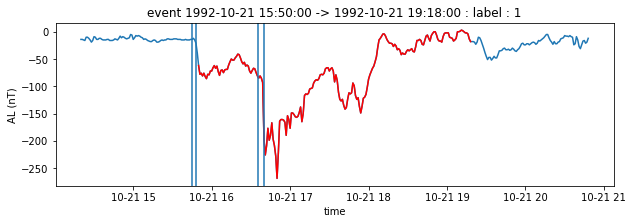

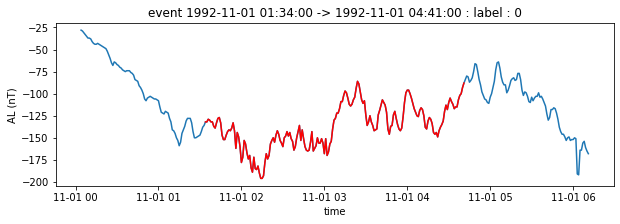

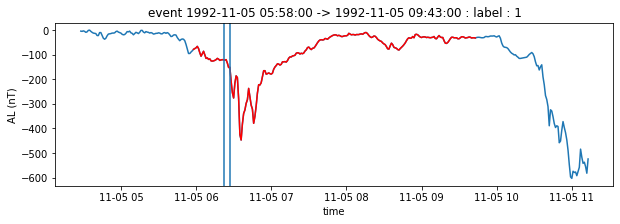

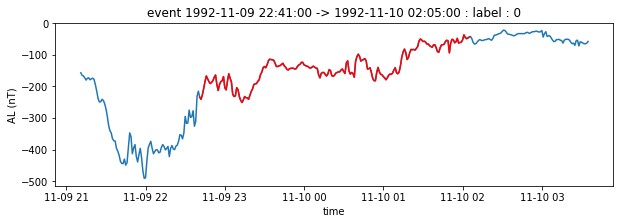

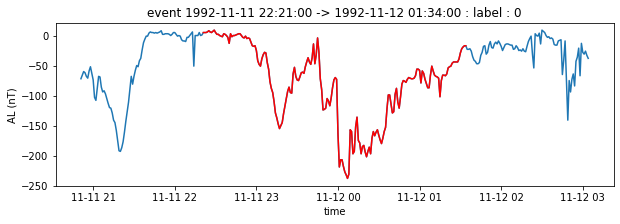

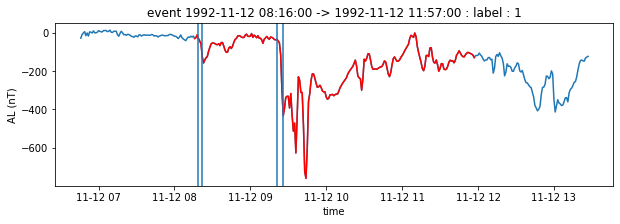

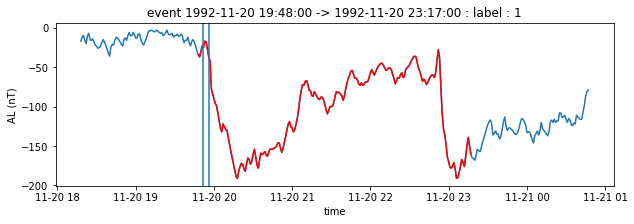

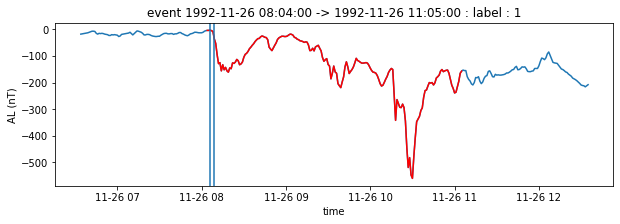

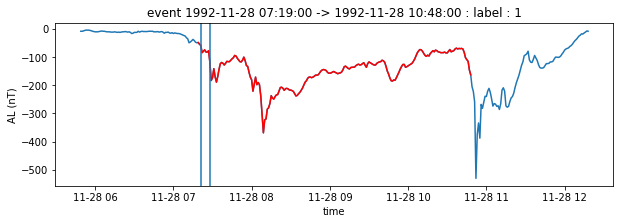

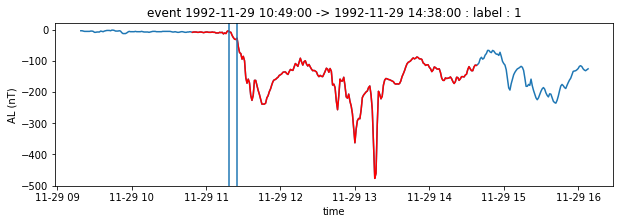

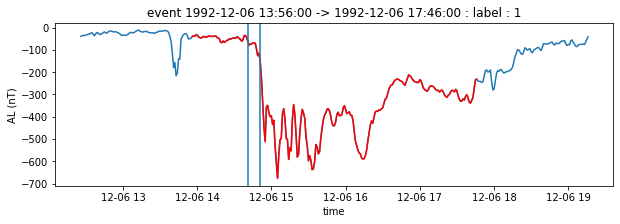

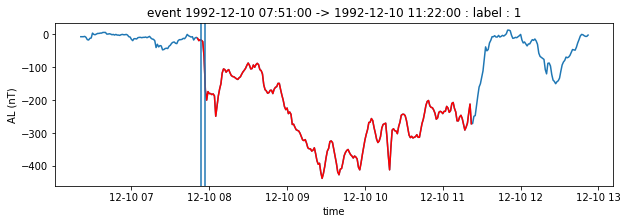

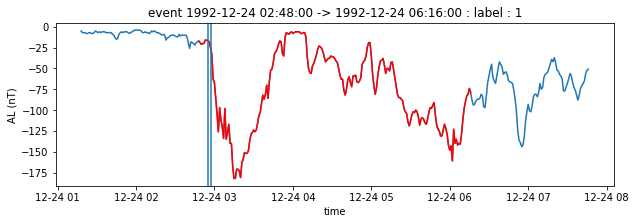

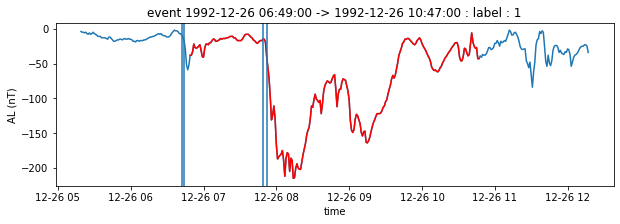

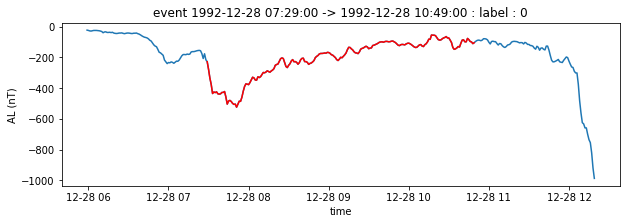

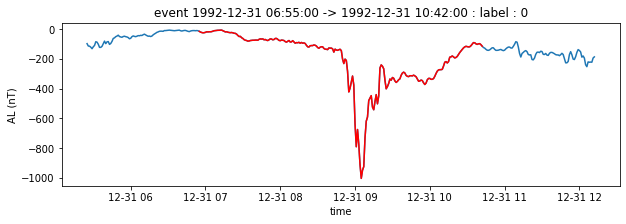

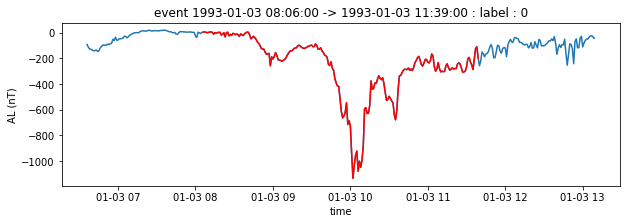

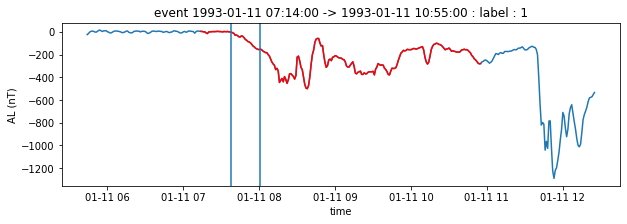

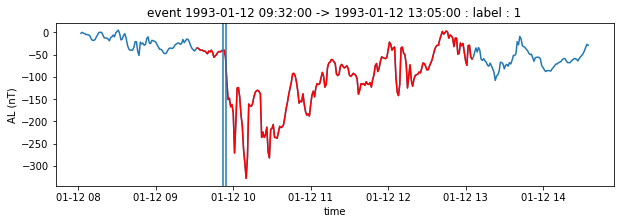

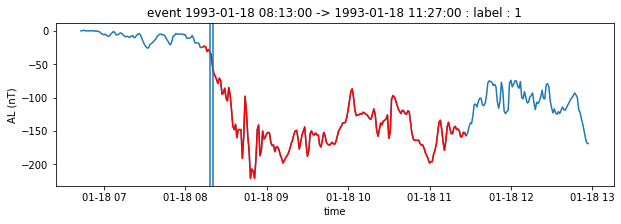

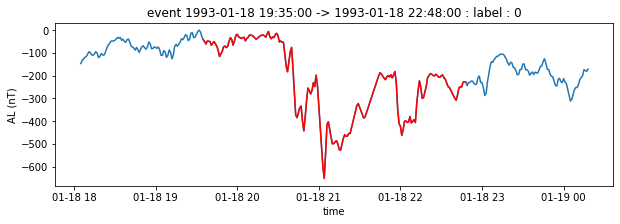

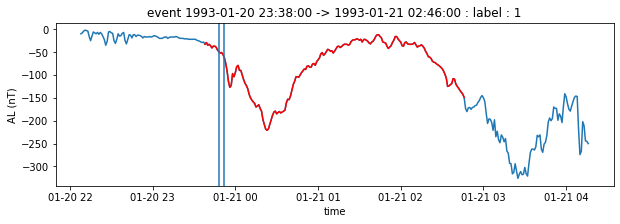

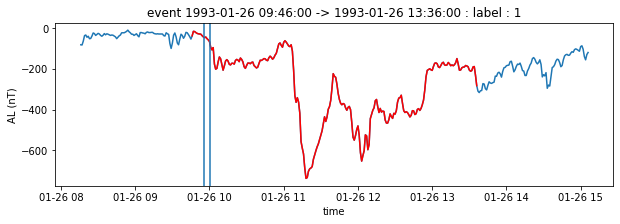

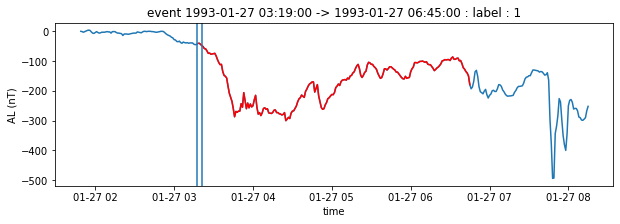

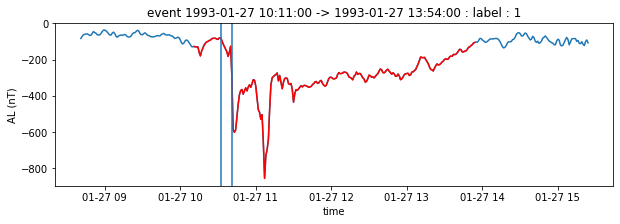

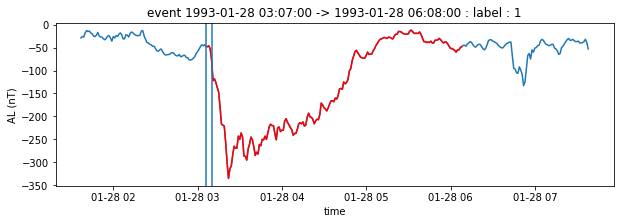

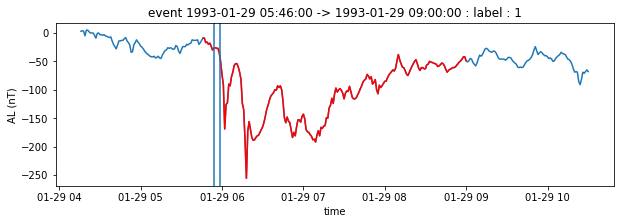

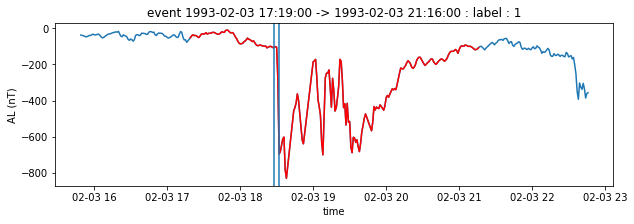

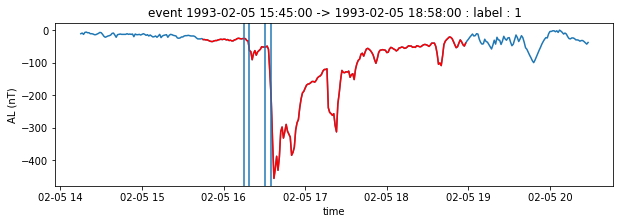

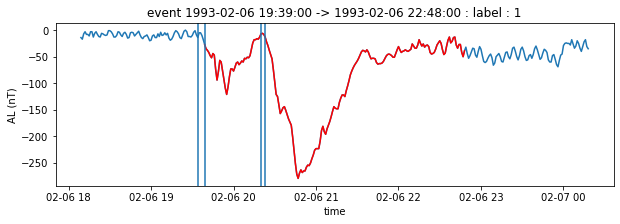

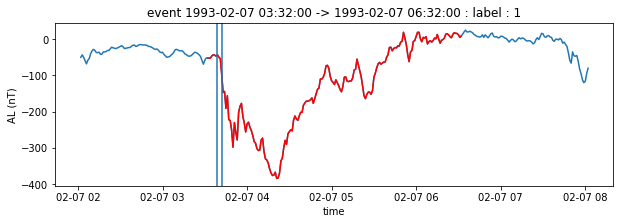

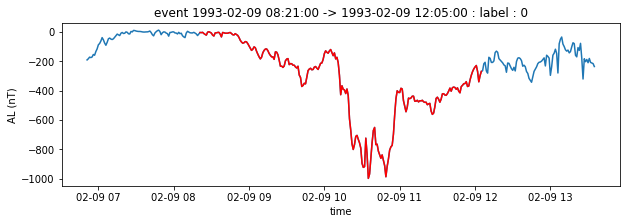

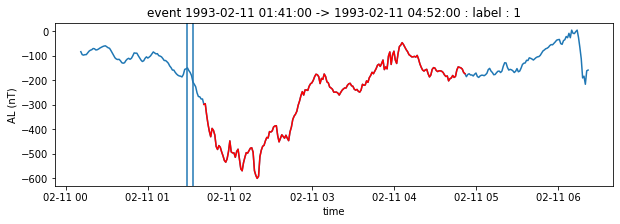

In [17]:
event_dates=[[labeled_data.index[a],labeled_data.index[b]] \
                for [a,b] in substorm_events]
td=datetime.timedelta(hours=1.5)

#%matplotlib notebook
for [a,b] in event_dates:
    # check if the interval contains a substorm event
    interval_contains_label= labels.check_interval(a-td,b+td)
    fig=plt.figure(figsize=(10,3))
    plt.plot(original_data[a-td:b+td])
    plt.plot(original_data[a:b],c="r")
    if interval_contains_label:
        for [t1,t2] in labels.get_interval(a-td,b+td):
            plt.gca().axvline(t1)
            plt.gca().axvline(t2)
    plt.xlabel("time")
    plt.ylabel("AL (nT)")
    plt.title("event {} -> {} : label : {}".format(a,b,interval_contains_label))
    plt.show()
    plt.close(fig)

### Substorm catalog

Convert the predictions to a catalog of events that can be read in AMDA.

In [18]:
# print the resulting catalogue
def print_catalog(c):
    for [b,e] in c:
        print("{} {}".format(b.strftime("%Y-%m-%dT%H:%M:%S"),\
                         e.strftime("%Y-%m-%dT%H:%M:%S")))
print_catalog(event_dates)

1992-10-21T15:50:00 1992-10-21T19:18:00
1992-11-01T01:34:00 1992-11-01T04:41:00
1992-11-05T05:58:00 1992-11-05T09:43:00
1992-11-09T22:41:00 1992-11-10T02:05:00
1992-11-11T22:21:00 1992-11-12T01:34:00
1992-11-12T08:16:00 1992-11-12T11:57:00
1992-11-20T19:48:00 1992-11-20T23:17:00
1992-11-26T08:04:00 1992-11-26T11:05:00
1992-11-28T07:19:00 1992-11-28T10:48:00
1992-11-29T10:49:00 1992-11-29T14:38:00
1992-12-06T13:56:00 1992-12-06T17:46:00
1992-12-10T07:51:00 1992-12-10T11:22:00
1992-12-24T02:48:00 1992-12-24T06:16:00
1992-12-26T06:49:00 1992-12-26T10:47:00
1992-12-28T07:29:00 1992-12-28T10:49:00
1992-12-31T06:55:00 1992-12-31T10:42:00
1993-01-03T08:06:00 1993-01-03T11:39:00
1993-01-11T07:14:00 1993-01-11T10:55:00
1993-01-12T09:32:00 1993-01-12T13:05:00
1993-01-18T08:13:00 1993-01-18T11:27:00
1993-01-18T19:35:00 1993-01-18T22:48:00
1993-01-20T23:38:00 1993-01-21T02:46:00
1993-01-26T09:46:00 1993-01-26T13:36:00
1993-01-27T03:19:00 1993-01-27T06:45:00
1993-01-27T10:11:00 1993-01-27T13:54:00


## Correcting labels

Some samples have incorect labels and hinder the learning process. In this step we check the events that were predicted by our model and note some additional events. These events will be added to our collection of labels and the model will be trained over the new dataset.

Each date `t` in `new_labels` corresponds to the onset of a substorm (in my subjective opinion). We add the interval `[t, t + 5 min]` to the label collection.

In [19]:
# additional onset times defined here
new_labels=["1992-10-16T00:00:00","1992-10-17T05:30:00",\
"1992-11-01T21:45:00","1992-11-08T22:05:00","1992-11-16T15:15:00",\
"1992-12-11T07:50:00","1992-12-11T14:30:00","1992-12-14T19:50:00",\
"1992-12-19T11:30:00","1992-12-23T03:30:00","1992-12-23T09:15:00",\
"1992-12-28T06:30:00","1993-01-06T21:40:00","1993-01-07T09:05:00",\
"1993-01-07T14:30:00","1993-01-15T09:55:00","1993-01-28T18:40:00",\
"1993-01-29T16:50:00","1993-02-12T04:40:00"]

Add the events to the label collection, each event has a duration of `5` minutes.

In [20]:
# add labels to labels
td=datetime.timedelta(minutes=5)
for t in new_labels:
    a=datetime.datetime.strptime(t,"%Y-%m-%dT%H:%M:%S")
    b=a+td
    labels.labels.append([a, b])
# make training labels
y_event_presence2=np.array([labels.check_interval(labeled_data.index[i-h_w],\
                                                 labeled_data.index[i+h_w])\
                           for i in range(N)]).astype(int)

# count classes
print("Classes:\n\t1: {}\n\t0: {}".format(np.sum(y_event_presence==1), \
                                         np.sum(y_event_presence==0)))

# balance the resulting dataset
x_balanced2,y_balanced2=balance_classes(x_windows,y_event_presence2,.5)
print("Balanced data shape :\n\tx.shape : {}\n\ty.shape : {}".format(x_balanced2.shape, y_balanced2.shape))

Classes:
	1: 11807
	0: 167959
Balanced data shape :
	x.shape : (30264, 180)
	y.shape : (30264,)


Now create a new `BinaryClassifierDetector` object and train it.

Training stop status : validation increased, exceeded patience


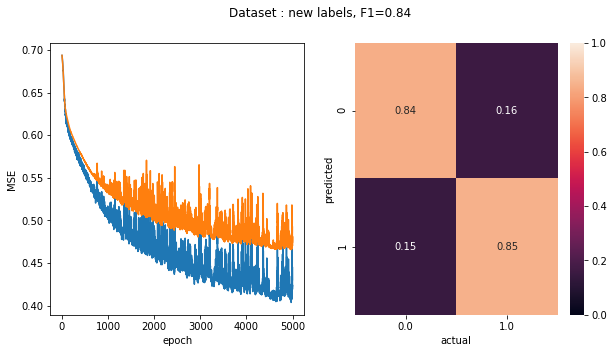

In [21]:
detector =  BinaryClassifierDetector(MyBinClass)
detector.fit(x_balanced2,y_balanced2,\
             lr=.1,\
             patience=100,\
             validation_tol=1.e-5,\
             max_epochs=5000,\
             verbose=False)
print("Training stop status : {}".format(detector.train_history.stop_status))
fig=plot_losses_and_confusion(detector, x_balanced2,y_balanced2, "Dataset : {}".format("new labels"), figsize=(10,5))

The model has a better F1 score than its previous instance. Lets view the detection results. We plot the distribution of event lengths. Only events whose duration is between `180` and `240` minutes are kept.

Total number of events : 206


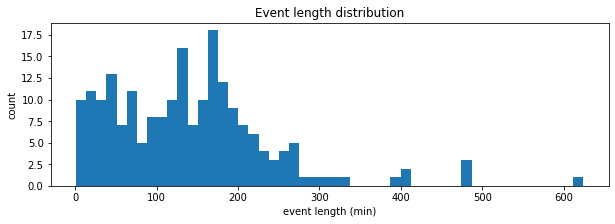

Number of events : 36


In [22]:
prediction=detector.predict(x_windows)
mc=majority_vote(prediction, 180)
substorm_events=prediction_to_catalogue(mc)
print("Total number of events : {}".format(len(substorm_events)))

event_lengths=[b-a for [a,b] in substorm_events]
plt.figure(figsize=(10,3))
plt.title("Event length distribution")
plt.xlabel("event length (min)")
plt.ylabel("count")
plt.hist(event_lengths, bins=50)
plt.show()

substorm_events = [[a,b] for [a,b] in substorm_events if 180<=b-a<=240]
print("Number of events : {}".format(len(substorm_events)))

Get the event catalog and print it.

In [23]:
catalog=[[labeled_data.index[a],labeled_data.index[b]] \
                for [a,b] in substorm_events]
print_catalog(catalog)

1992-10-17T05:32:00 1992-10-17T08:36:00
1992-10-21T15:49:00 1992-10-21T19:27:00
1992-11-01T21:39:00 1992-11-02T00:53:00
1992-11-12T08:21:00 1992-11-12T11:36:00
1992-11-19T03:55:00 1992-11-19T07:42:00
1992-11-26T08:02:00 1992-11-26T11:15:00
1992-12-05T02:44:00 1992-12-05T06:26:00
1992-12-05T06:53:00 1992-12-05T10:19:00
1992-12-11T07:50:00 1992-12-11T10:54:00
1992-12-11T14:02:00 1992-12-11T17:34:00
1992-12-14T19:32:00 1992-12-14T23:00:00
1992-12-15T09:42:00 1992-12-15T12:45:00
1992-12-15T20:00:00 1992-12-15T23:54:00
1992-12-17T07:21:00 1992-12-17T10:37:00
1992-12-19T18:08:00 1992-12-19T21:17:00
1992-12-23T03:38:00 1992-12-23T07:09:00
1992-12-24T02:51:00 1992-12-24T06:02:00
1992-12-26T07:06:00 1992-12-26T10:47:00
1992-12-28T06:42:00 1992-12-28T10:03:00
1992-12-31T07:20:00 1992-12-31T10:23:00
1993-01-06T04:29:00 1993-01-06T08:17:00
1993-01-06T21:26:00 1993-01-07T00:27:00
1993-01-07T14:16:00 1993-01-07T17:45:00
1993-01-09T06:16:00 1993-01-09T09:42:00
1993-01-11T07:30:00 1993-01-11T10:48:00


### Viewing the results

Each event is represented below. In blue is the `AL index` value around the event. In red is represented the event that was detected by the model.

If the interval contains a substorm event label then the extreme values of its time period are represented as vertical lines.

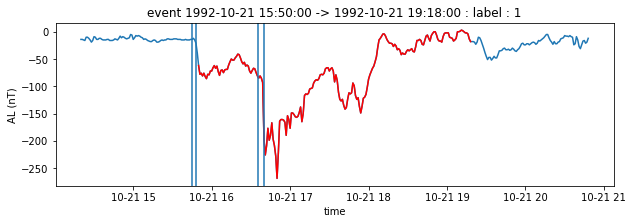

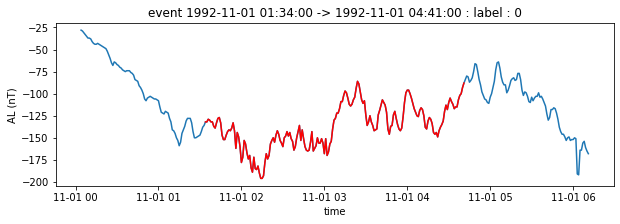

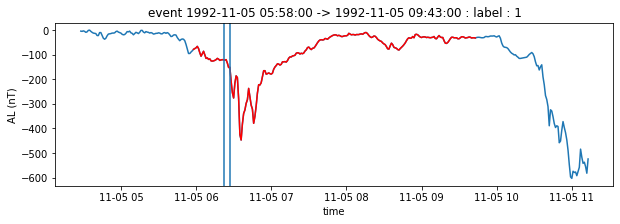

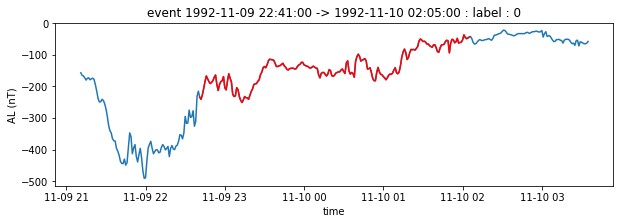

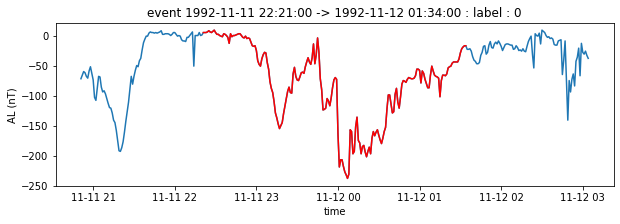

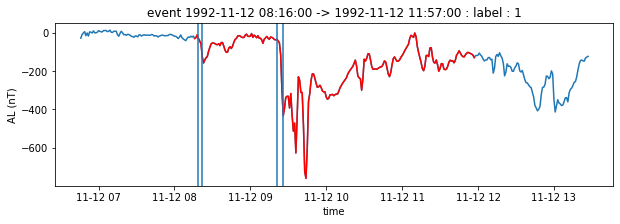

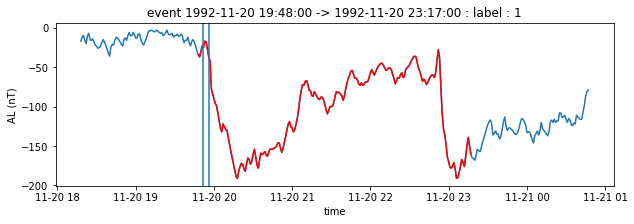

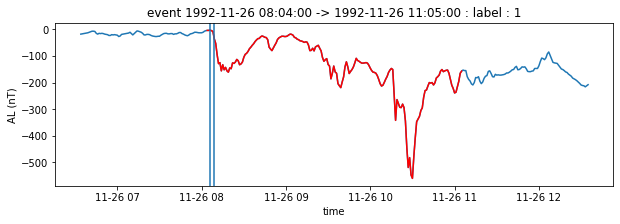

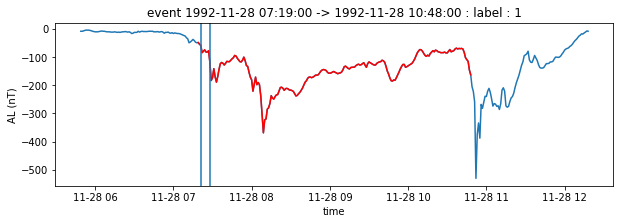

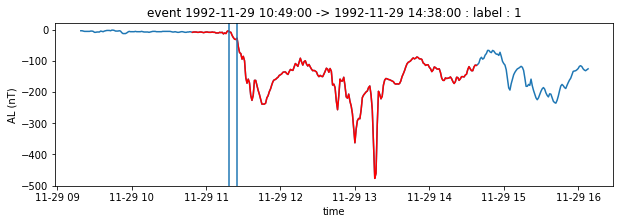

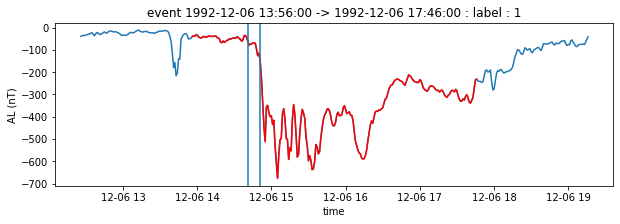

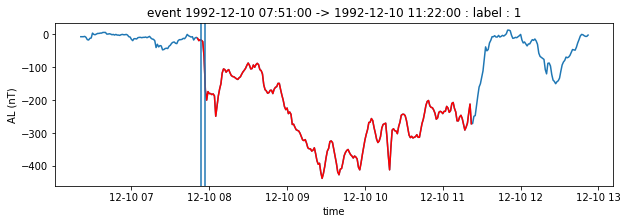

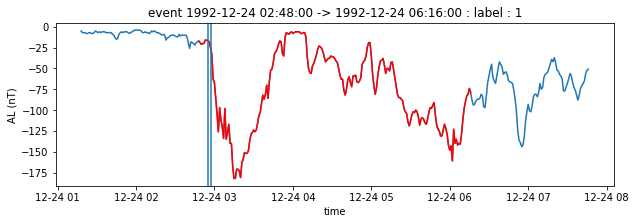

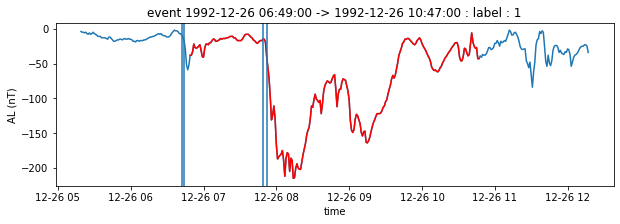

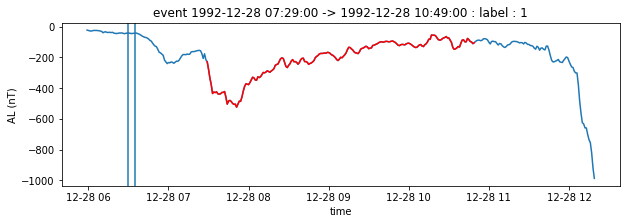

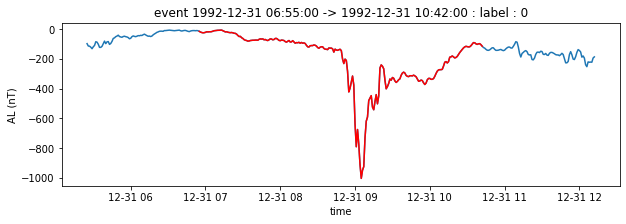

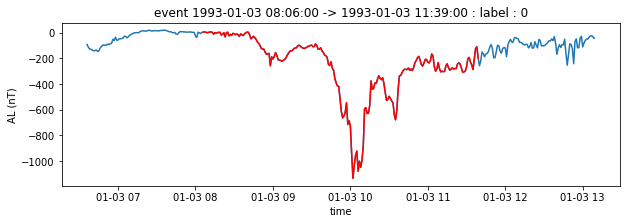

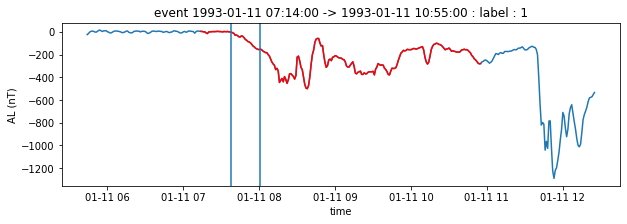

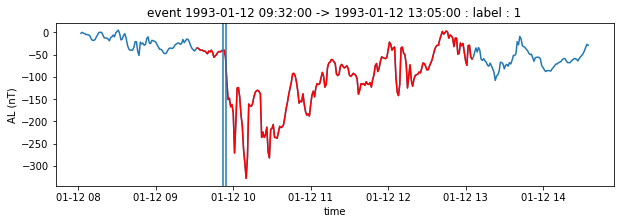

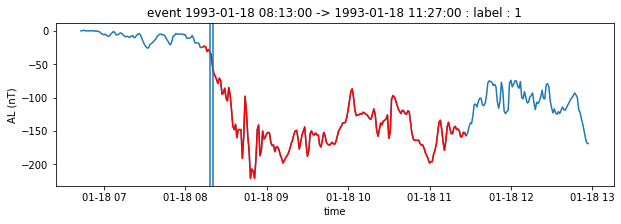

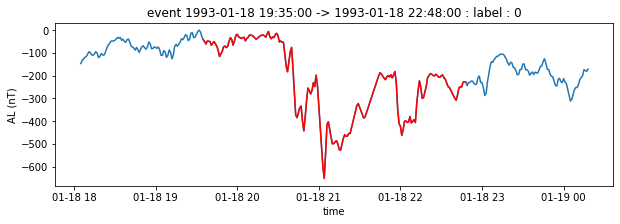

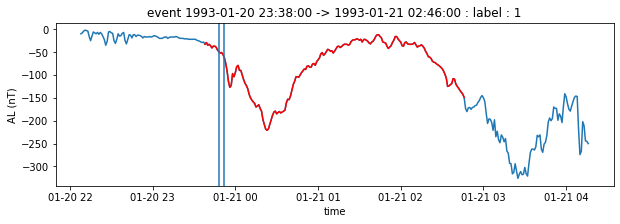

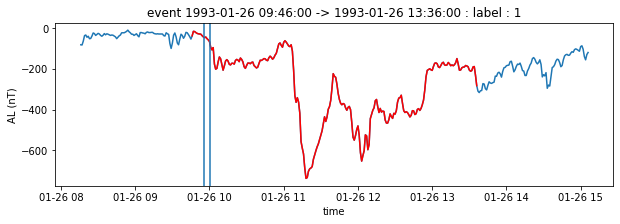

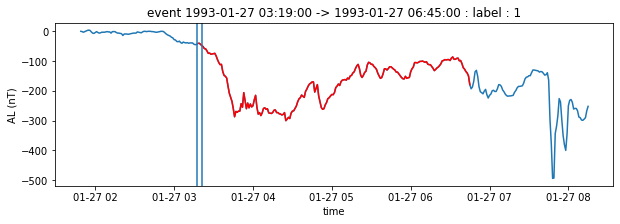

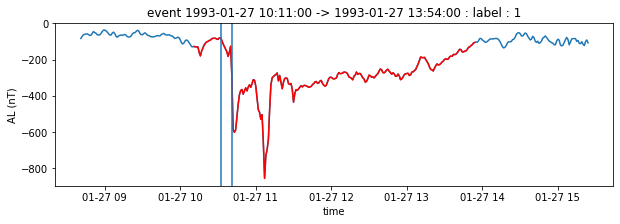

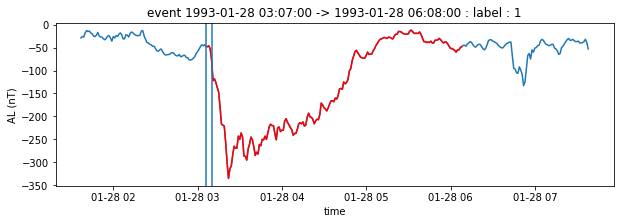

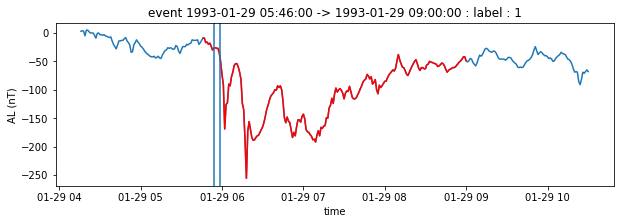

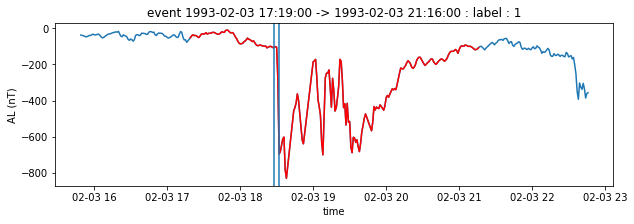

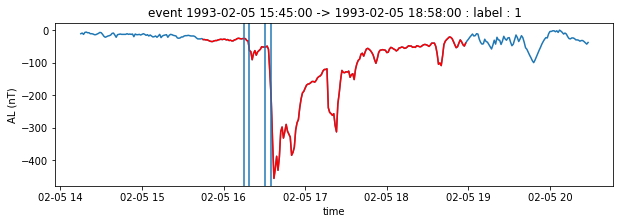

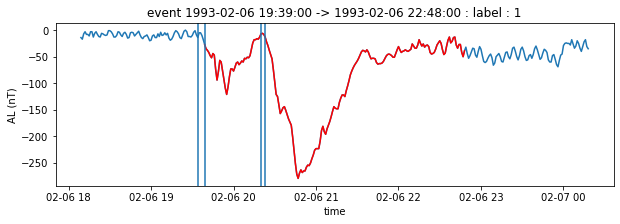

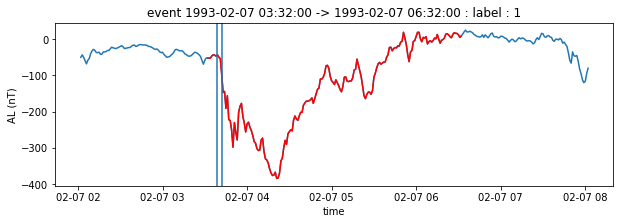

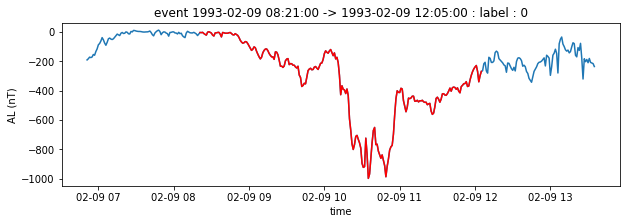

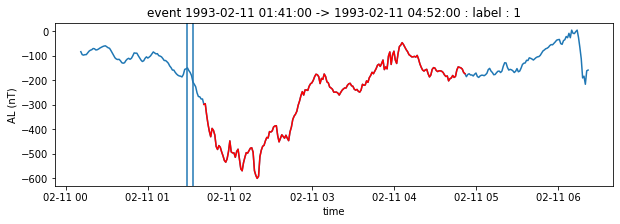

In [24]:
td=datetime.timedelta(hours=1.5)
for [a,b] in event_dates:
    # check if the interval contains a substorm event
    interval_contains_label= labels.check_interval(a-td,b+td)
    fig=plt.figure(figsize=(10,3))
    plt.plot(original_data[a-td:b+td])
    plt.plot(original_data[a:b],c="r")
    if interval_contains_label:
        for [t1,t2] in labels.get_interval(a-td,b+td):
            plt.gca().axvline(t1)
            plt.gca().axvline(t2)
    plt.xlabel("time")
    plt.ylabel("AL (nT)")
    plt.title("event {} -> {} : label : {}".format(a,b,interval_contains_label))
    plt.show()
    plt.close(fig)